In [16]:
import warnings
disable_warnings = warnings.filterwarnings('ignore')
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
# from statsforecast import StatsForecast
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, pacf, acf
from sklearn.metrics import mean_squared_error



In [2]:
orders_train = pd.read_csv('orders_train.txt', sep=';', encoding='utf8')
orders_class = pd.read_csv('orders_class.txt', sep=';', encoding='utf8')

In [3]:
df_whole = pd.concat([orders_train, orders_class], ignore_index=True)
df_whole

,orderID,orderDate,articleID,colorCode,sizeCode,productGroup,quantity,price,rrp,voucherID,voucherAmount,customerID,deviceID,paymentMethod,returnQuantity
0,a1000001,2014-01-01,i1000382,1972,44,3.0,1,10.00,29.99,0,0.0,c1010575,2,BPRG,0.0
1,a1000001,2014-01-01,i1000550,3854,44,3.0,1,20.00,39.99,0,0.0,c1010575,2,BPRG,0.0
2,a1000002,2014-01-01,i1001991,2974,38,8.0,1,35.00,49.99,0,0.0,c1045905,4,BPRG,0.0
3,a1000002,2014-01-01,i1001999,1992,38,8.0,1,49.99,49.99,0,0.0,c1045905,4,BPRG,1.0
4,a1000003,2014-01-01,i1001942,1968,42,8.0,1,10.00,35.99,0,0.0,c1089295,2,PAYPALVC,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666258,a1855500,2015-12-31,i1004262,20363,38,1231.0,1,29.99,29.99,0,0.0,c1225101,5,BPRG,NaN
2666259,a1855501,2015-12-31,i1000397,1000,44,3.0,1,17.99,17.99,0,0.0,c1065053,5,PAYPALVC,NaN
2666260,a1855501,2015-12-31,i1001099,3085,42,3.0,1,9.00,29.99,0,0.0,c1065053,5,PAYPALVC,NaN
2666261,a1855501,2015-12-31,i1004207,10107,42,1231.0,1,17.99,17.99,0,0.0,c1065053,5,PAYPALVC,NaN


In [4]:
df_orders = df_whole[["orderDate","quantity"]].groupby("orderDate").sum()
df_orders

,quantity
orderDate,
2014-01-01,1245
2014-01-02,1586
2014-01-03,1709
2014-01-04,2495
2014-01-05,3485
...,...
2015-12-27,2783
2015-12-28,4968
2015-12-29,4061


In [25]:
df_orders_train = df_orders.loc[:'2015-11-30']
df_orders_test = df_orders.loc['2015-12-01':'2015-12-14']


In [8]:
fig = px.line(df_orders_train, x=df_orders_train.index, y="quantity", title='Daily sales', template="simple_white")
fig.add_trace(go.Scatter(x=df_orders_test.index, y=df_orders_test["quantity"], mode='lines', name='Test Quantity'))
fig.update_layout(title_x=0.5, margin={'l': 30, 'b': 40, 't': 30, 'r': 40}, hovermode='x unified', hoverlabel=dict(bgcolor="white"))
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Quantity")
fig.show()

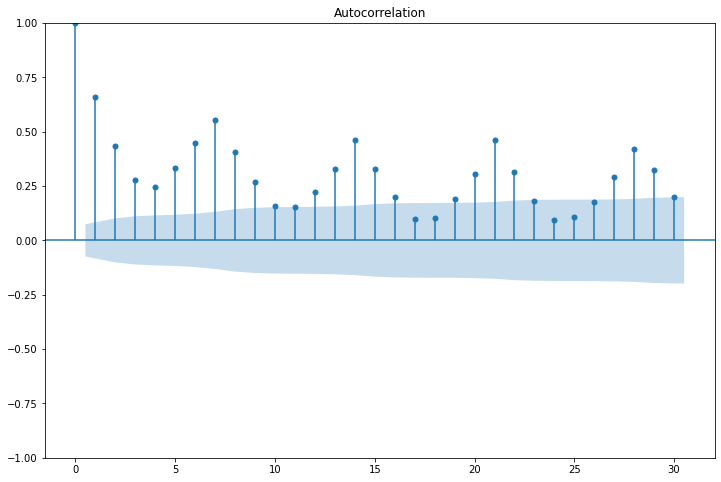

In [12]:
# Generate the ACF plot using statsmodels
acf_fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the size as needed (width, height)
plot_acf(df_orders_train, lags=30, ax=ax)
plt.show()

In [13]:
# Perform the ADF test on the time series
result = adfuller(df_orders_train['quantity'])

# Extract the test statistic and p-value from the result
test_statistic = result[0]
p_value = result[1]

# Print the test statistic and p-value
print(f'Test statistic: {test_statistic:.4f}')
print(f'p-value: {p_value:.4f}')

Test statistic: -2.5305
p-value: 0.1082


In [14]:
# Compute the first and second differences of the time series
diff1 = df_orders_train['quantity'].diff().dropna()
diff2 = diff1.diff().dropna()

# Perform the ADF test on the differences and print the results
for i, diff in enumerate([diff1, diff2], start=1):
    result = adfuller(diff)
    print(f'{i} difference: Test statistic = {result[0]:.4f}, p-value = {result[1]:.4f}')

1 difference: Test statistic = -8.2093, p-value = 0.0000
2 difference: Test statistic = -11.9449, p-value = 0.0000


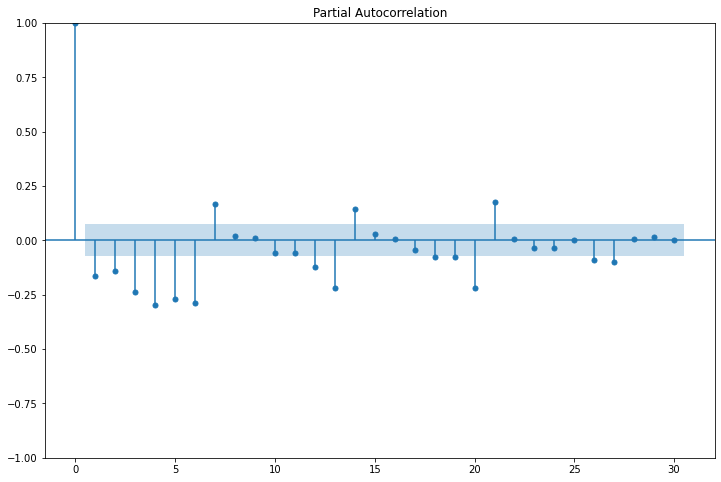

In [20]:
pacf_fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the size as needed (width, height)
plot_pacf(diff1, lags=30, ax=ax)
plt.show()

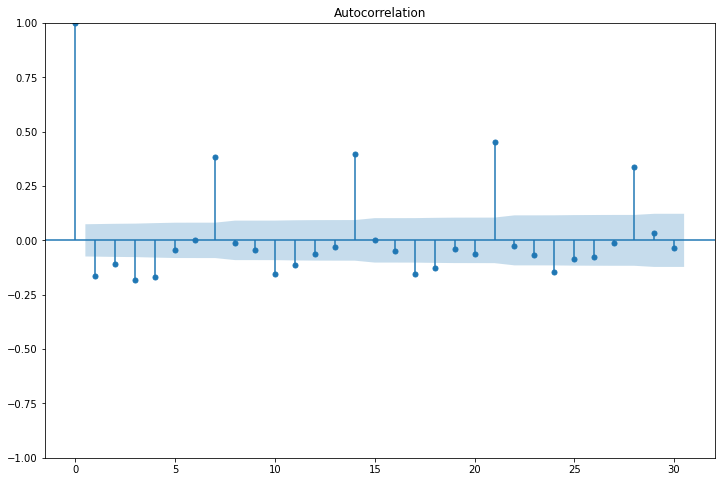

In [21]:
acf_fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the size as needed (width, height)
plot_acf(diff1, lags=30, ax=ax)
plt.show()

In [65]:
# Define the ARIMA model with p=6, d=1, and q=7
model = ARIMA(df_orders_train['quantity'], order=(7, 1, 7), freq='D')

# Fit the model to the data
model_fit = model.fit()

# Print the summary of the model
print(model_fit.summary())

# Make predictions for the next 31 time steps
forecast = model_fit.forecast(steps=14)

# Print the forecasted values
print(forecast)

                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  699
Model:                 ARIMA(7, 1, 7)   Log Likelihood               -5471.363
Date:                Wed, 26 Jul 2023   AIC                          10972.727
Time:                        10:55:58   BIC                          11040.950
Sample:                    01-01-2014   HQIC                         10999.102
                         - 11-30-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2477      0.035     -7.146      0.000      -0.316      -0.180
ar.L2         -0.2601      0.034     -7.763      0.000      -0.326      -0.194
ar.L3         -0.2677      0.033     -8.019      0.0

In [66]:
fig = px.line(df_orders["2015-10-01":], x=df_orders["2015-10-01":].index, y="quantity", title='Daily sales', template="simple_white")
# fig.update_traces(line=dict(width=1.5))
fig.add_trace(go.Scatter(x=forecast.index, y=forecast.values, mode='lines', name='Forecast Quantity'))
fig.update_layout(title_x=0.5, margin={'l': 30, 'b': 40, 't': 30, 'r': 40}, hovermode='x unified', hoverlabel=dict(bgcolor="white"))
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Quantity")
fig.show()

In [67]:
rmse = mean_squared_error(df_orders_test['quantity'], forecast, squared=False)
rmse

886.6168080293307

In [267]:
# df_orders_train["holiday"] = 0
# df_orders_train.loc[["2014-12-24", "2014-12-31"], "holiday"] = 1
# df_orders_test["holiday"] = 0
# df_orders_test.loc[["2015-12-24", "2015-12-31"], "holiday"] = 1

In [268]:
# # Convert the index to a datetime index
# df_orders_train.index = pd.to_datetime(df_orders_train.index)
# df_orders_test.index = pd.to_datetime(df_orders_test.index)

# # Create dummy variables for 'day_of_week' in both DataFrames
# df_dummies_train = pd.get_dummies(df_orders_train.index.dayofweek, prefix='day_of_week')
# df_dummies_train.index = df_orders_train.index
# df_dummies_test = pd.get_dummies(df_orders_test.index.dayofweek, prefix='day_of_week')
# df_dummies_test.index = df_orders_test.index


# # Rename the columns of the dummy variable DataFrame to correspond to the name of the days
# df_dummies_train.columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# df_dummies_test.columns = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# # Concatenate the original DataFrame and the dummy variable DataFrame
# df_orders_train = pd.concat([df_orders_train, df_dummies_train], axis=1)
# df_orders_test = pd.concat([df_orders_test, df_dummies_test], axis=1)


In [44]:
# Define the SARIMA model with p=6, d=1, q=7, P=1, D=1, and Q=1
model = SARIMAX(endog = df_orders_train['quantity'], exog=df_orders_train.iloc[:, 1:] ,order=(3, 1, 3), seasonal_order=(4, 1, 4, 7), freq='D')

# Fit the model to the data
model_fit = model.fit()

# Print the summary of the model
print(model_fit.summary())

# Make predictions for the next 31 time steps
exog_forecast = df_orders_test.iloc[:, 1:]
forecast = model_fit.forecast(steps=31, exog=exog_forecast)

# Print the forecasted values
print(forecast)

ValueError: zero-size array to reduction operation maximum which has no identity

In [75]:
# Define the SARIMA model with p=6, d=1, q=7, P=1, D=1, and Q=1
model = SARIMAX(df_orders_train['quantity'],order=(3, 1, 3), seasonal_order=(4, 1, 4, 7), freq='D')

# Fit the model to the data
model_fit = model.fit()

# Print the summary of the model
print(model_fit.summary())

# Make predictions for the next 31 time steps
# exog_forecast = df_orders_test.iloc[:, 1:]
forecast = model_fit.forecast(steps=14)

# Print the forecasted values
print(forecast)

                                          SARIMAX Results                                           
Dep. Variable:                                     quantity   No. Observations:                  699
Model:             SARIMAX(3, 1, 3)x(4, 1, [1, 2, 3, 4], 7)   Log Likelihood               -5443.349
Date:                                      Wed, 26 Jul 2023   AIC                          10916.699
Time:                                              11:02:29   BIC                          10984.771
Sample:                                          01-01-2014   HQIC                         10943.028
                                               - 11-30-2015                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3799      0.084  

In [76]:
fig = px.line(df_orders["2015-10-01":], x=df_orders["2015-10-01":].index, y="quantity", title='Daily sales', template="simple_white")
# fig.update_traces(line=dict(width=1.5))
fig.add_trace(go.Scatter(x=forecast.index, y=forecast.values, mode='lines', name='Forecast Quantity'))
fig.update_layout(title_x=0.5, margin={'l': 30, 'b': 40, 't': 30, 'r': 40}, hovermode='x unified', hoverlabel=dict(bgcolor="white"))
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Quantity")
fig.show()

In [77]:
rmse = mean_squared_error(df_orders_test['quantity'], forecast, squared=False)
rmse

700.7036181691961